In [1]:
library(tidyverse)
library(patchwork)
library(magrittr)
library(brms)
library(ggforce)
library(magick)
library(cowplot)
theme_set(theme_classic(base_size = 20))
source("../color_df.R")
options(repr.plot.width = 20, repr.plot.height = 12, repr.plot.res = 200)


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: Rcpp

Loading 'brms' package (version 2.13.5). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignet

In [2]:
#linkedsel data
linkedsel_val_df <- read_csv("linkedsel_predDF.csv")

theta_plot_df <- distinct(select(linkedsel_val_df, lower, value, upper, pop))

mean_pi_df <- 
    linkedsel_val_df %>% 
    group_by(pop) %>% 
    summarise(pi = mean(pi))

linkedsel_best_mod  <- read_csv("linkedsel_best_modDF.csv")
mu_int <- 8
best_fit_list <- readRDS(str_glue("bgs_bestfit_mu-{mu_int}.rds"))
aic_df <- map_df(best_fit_list, ~ .x$aic_df)
conf_df <- map_df(best_fit_list, ~ .x$conf_df) %>% mutate(pop = str_remove_all(pop, "(v5--|.100000BP)"))
pred_df <- map_df(best_fit_list, ~ .x$pred_df)


#aMK data
pred_df <- read_csv(, file = "aMK_predDF.csv")
full_pred <- read_csv(, file = "aMK_allpredDF.csv")


model_plot_df <- filter(conf_df, model %in% c("full", "intercept"), param == "theta") %>%
    full_join(
        mutate(color_df, pop = str_replace_all(pop, "(Teo|LR)_", "\\1--")), 
        conf_df, , by = "pop") %>% 
    filter(!pop %in% c("LR--random2_Palmar_Chico", "LR--Palmar_Chico", "Teo--random2_Palmar_Chico", "Teo--Palmar_Chico")) %>% 
    drop_na() %>% 
    separate(pop, into = c("ssp", "pop"), sep = "--")


plot_df <- full_pred %>% 
  filter(nuc_type == "All") %>% 
  filter(!pop %in% c("LR_random2_Palmar_Chico", "LR_Palmar_Chico", "Teo_random2_Palmar_Chico", "Teo_Palmar_Chico"))  %>% 
  mutate(pop = str_remove_all(pop, "(LR_|Teo_)")) %>%
  full_join(., model_plot_df, by = c("pop", "ssp"))



── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  chr = col_character(),
  model = col_character(),
  mode = col_character(),
  pop = col_character(),
  param = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  model = col_character(),
  nLL = col_double(),
  AIC = col_double(),
  AIC_delta = col_double(),
  AIC_weight = col_double(),
  pop = col_character(),
  mode = col_character(),
  s = col_double(),
  mu = col_double(),
  h = col_double()
)



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────

In [17]:
tpt <- max(filter(linkedsel_val_df, pop == "LR--random1_Palmar_Chico")$rbp_i)
tpt <- 2
pc_theta <- filter(theta_plot_df, pop == "LR--random1_Palmar_Chico")$value
pc_pi <- filter(mean_pi_df, pop == "LR--random1_Palmar_Chico")$pi

pi_rate <- 
linkedsel_val_df %>% 
    filter(pop == "LR--random1_Palmar_Chico") %>%
    #mutate(rbp_i = log10(rbp_i)) %>% 
    ggplot()+
    geom_point(mapping = aes(rbp_i, pi), alpha = 0.2, size = 2) + 
    geom_ribbon(mapping = aes(x = rbp_i, ymin = low, ymax =  high), fill = "grey50", alpha = 0.2) +
    geom_hline(yintercept = pc_theta, lty = 2) +
    geom_point(aes(tpt, pc_theta), shape = 17, size = 4) +
    geom_point(aes(tpt, pc_pi), shape = 16, size = 4) +
    geom_line(mapping = aes(rbp_i, expected_pi), colour = "violetred") +
    xlab("cM/Mb") +
    facet_wrap(~pop, labeller = labeller(pop = c("LR--random1_Palmar_Chico" = "Landrace Palmar Chico"))) +
    ylab(expression(pi)) +
    facet_zoom(xlim = c(0, 2))
    


	Pearson's product-moment correlation

data:  value and alpha
t = 15.082, df = 12, p-value = 3.652e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9195593 0.9921475
sample estimates:
      cor 
0.9746216 



	Pearson's product-moment correlation

data:  value and alpha
t = 0.29192, df = 10, p-value = 0.7763
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5088210  0.6324597
sample estimates:
       cor 
0.09192354 


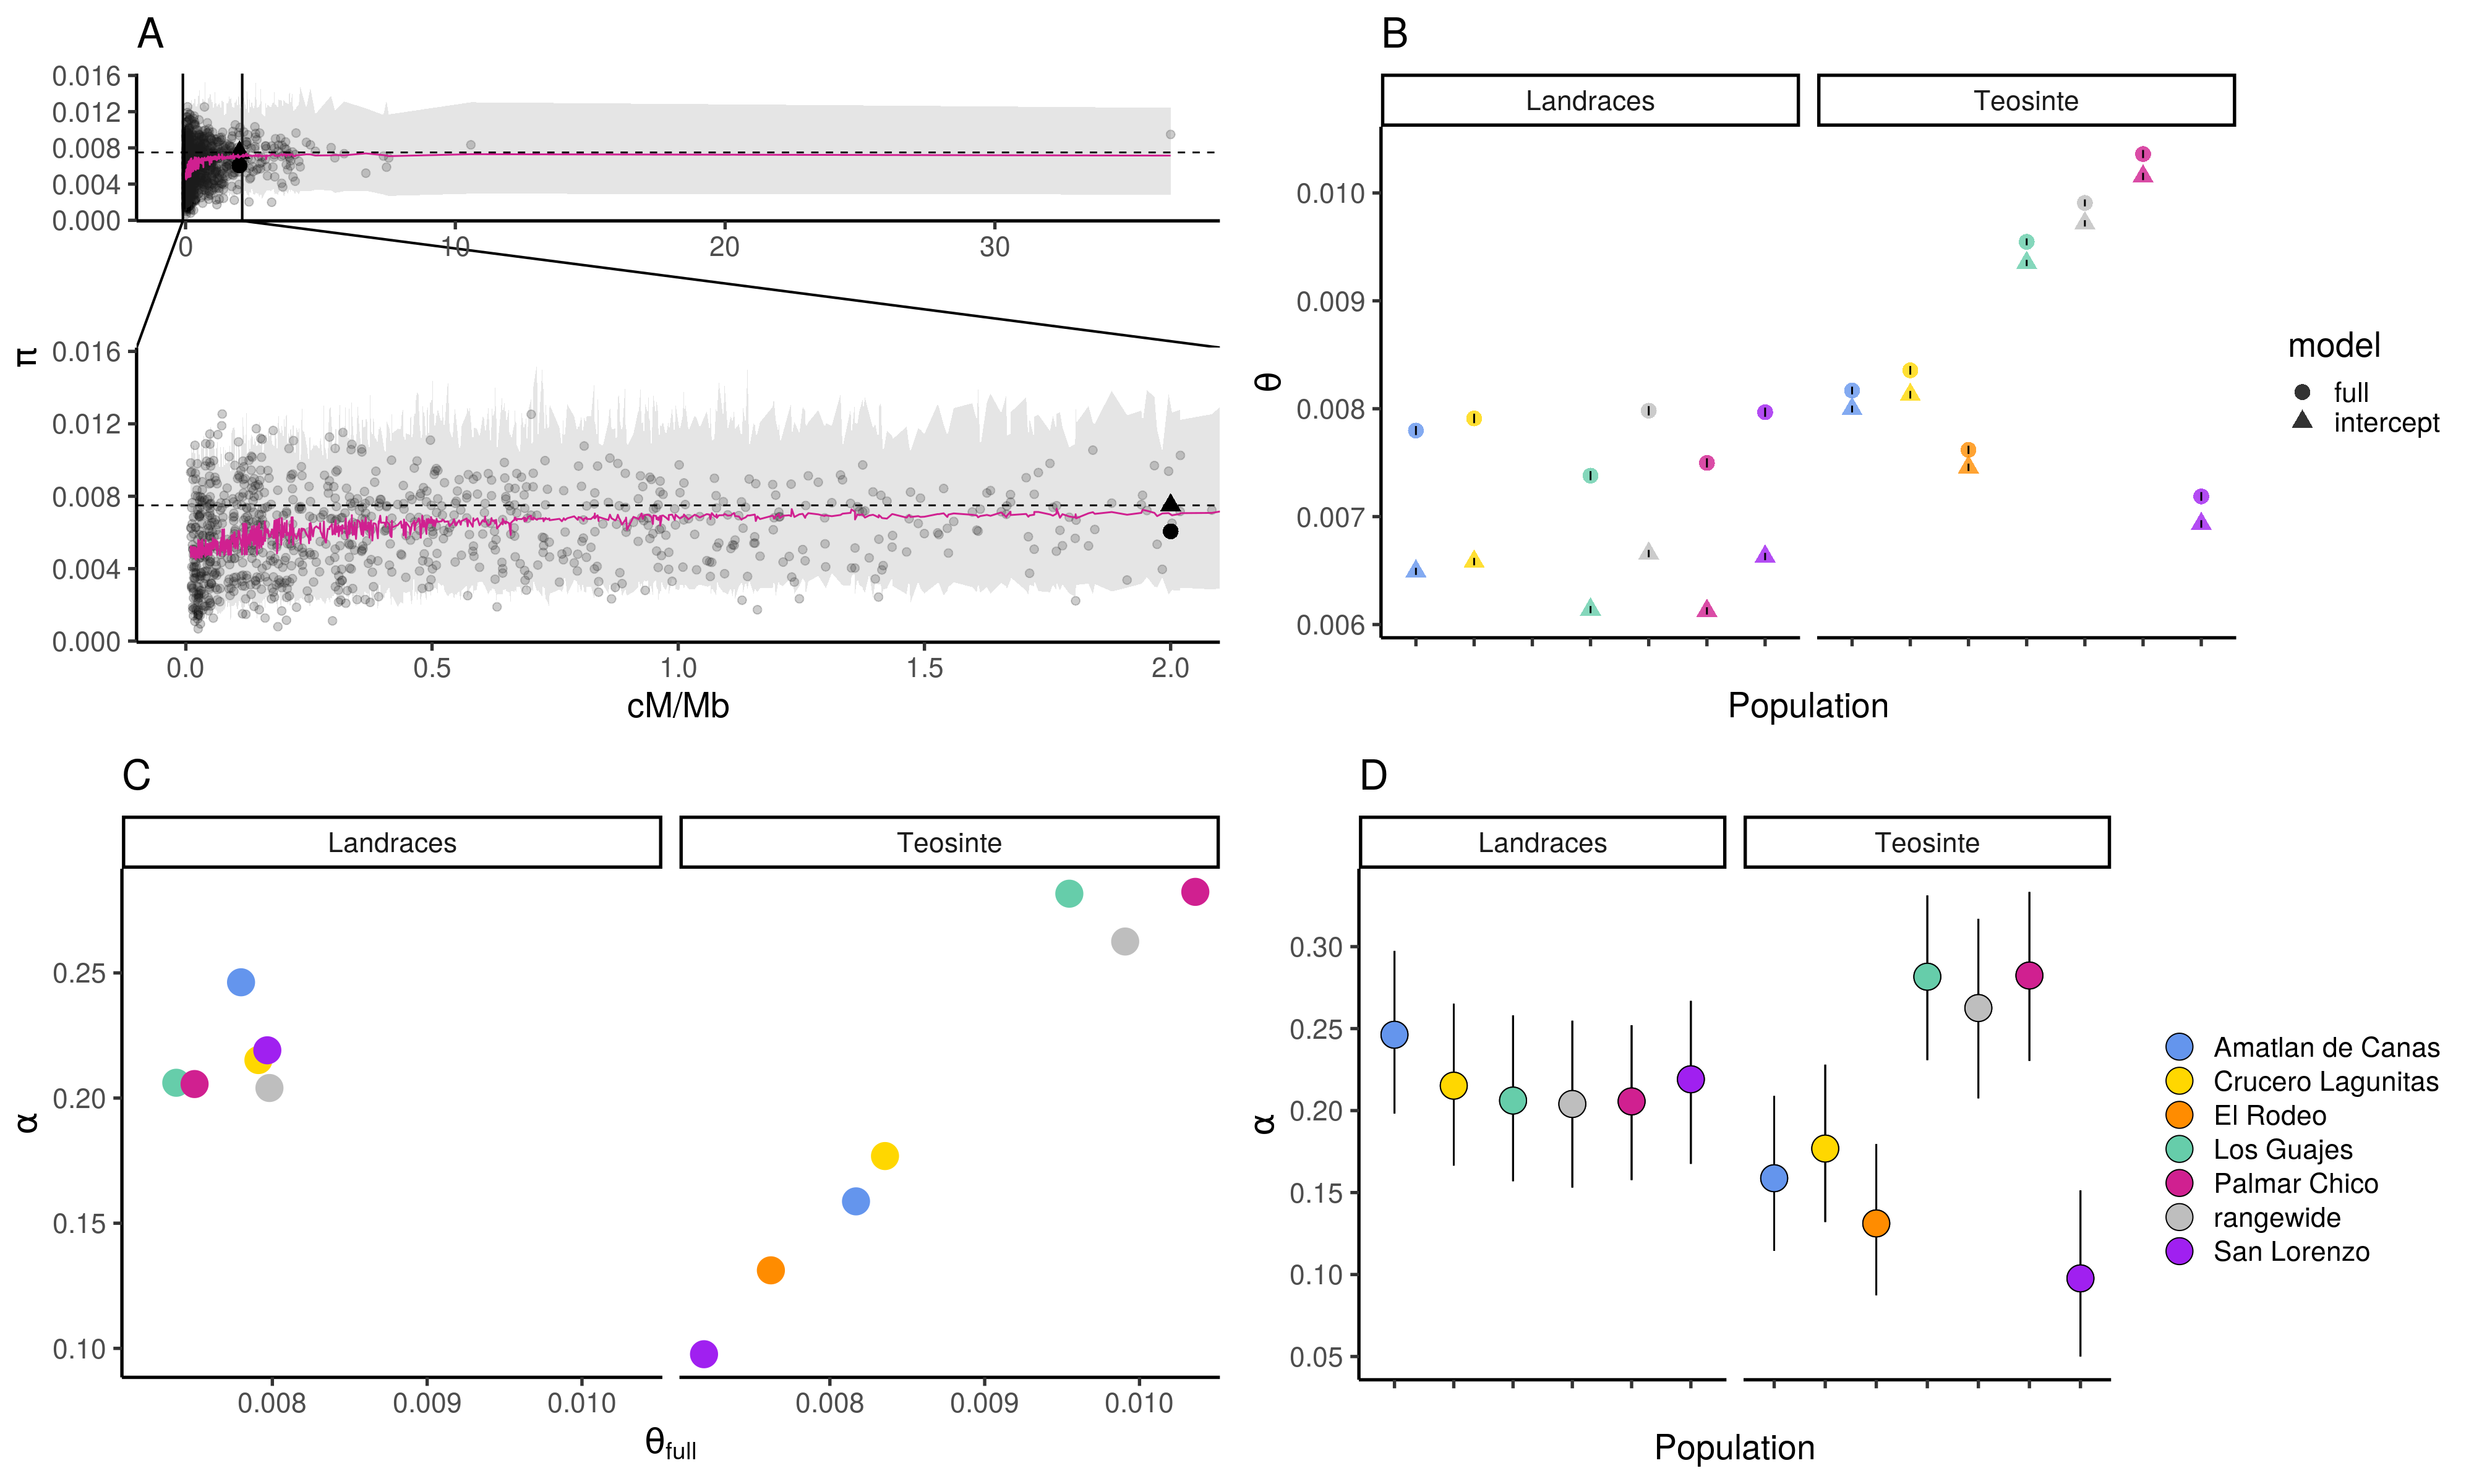

In [19]:

theta_plot <- 
 plot_df %>% 
    ggplot() +
    geom_point(data = , mapping = aes(pop, value, colour = color, shape = model), size = 4, alpha = 0.8, inherit.aes = F) +
    geom_segment(mapping = aes(x = pop, xend = pop, y = lower, yend = upper), colour = "black") +
    theme(axis.text.x = element_blank()) +
    facet_wrap(~ssp, labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Landraces"))) +
    xlab("\nPopulation") +
    ylab(expression(theta)) +
    scale_color_identity()


leg_df <- 
color_df %>% 
    mutate(pop = str_replace(pop, "LR_|Teo_", "")) %>% 
    filter(!pop %in% c("Palmar_Chico", "random2_Palmar_Chico")) %>%
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = ifelse(pop == "random", "rangewide", pop)) %>% 
    arrange(pop)


alpha_plot <- plot_df %>% 
    ggplot(aes(pop, alpha, fill = color)) +
    geom_segment(aes(x = pop, y = low, xend = pop, yend = high), colour = "black") +
    geom_point(size = 7, pch = 21) +
    facet_wrap(~ssp, scales = "free_x", nrow = 1, labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Landraces"))) +
    scale_fill_identity(guide = "legend", labels = str_remove_all(leg_df$pop, "random1 "), breaks = leg_df$color) +
    labs(fill = "") +
    ylab(expression(alpha)) +
    xlab("\nPopulation") +
    theme(axis.text.x = element_blank()) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

theta_alpha_plot <- 
plot_df %>% 
    filter(model == "full") %>% 
    ggplot(aes(value, alpha, colour = color)) +
    geom_point(size = 7) +
    #geom_segment(aes(x = value, y = low, xend = value, yend = high), colour = "black") +
    #geom_segment(aes(x = lower, y = alpha, xend = upper, yend = alpha), colour = "black") +
    facet_wrap(~ssp, scales = "fixed", labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Landraces"))) +
    xlab(expression(theta[full])) +
    ylab(expression(alpha)) +
    scale_color_identity()

with(filter(plot_df, ssp == "Teo"),  cor.test(value, alpha))
with(filter(plot_df, ssp == "LR"),  cor.test(value, alpha))


plot_grid(pi_rate + ggtitle("A"), theta_plot + ggtitle("B"), theta_alpha_plot + ggtitle("C"), alpha_plot + ggtitle("D")) +
    ggsave("../figures/Figure3.pdf", width = 18, height = 12)
